## Vision Transformer - V1

In [16]:
# ViT-v1 - Vision Transformer from scratch with PyTorch
import os
import math
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from itertools import cycle
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')

In [17]:
%run data.ipynb

Data root: d:\MSE\10.Deep Learning\Group_Final\ViT-Chest-Xray\Project\input
Total Trainable Data:  112120
Training set size:  60
Validation set size:  20
Test set size:  20
Images path: d:\MSE\10.Deep Learning\Group_Final\ViT-Chest-Xray\Project\input
Training batches: 2
Validation batches: 1
Test batches: 1


In [18]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU


In [19]:
# MLP block for Transformer
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = F.gelu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

In [20]:
# Patch Embedding Layer
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=32, in_channels=3, embed_dim=64):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        
        # Use Conv2d as the patch projection
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x):
        # x: (B, C, H, W)
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

In [21]:
# Visualize patches from sample image
def visualize_patches(dataloader, patch_size=32):
    """Visualize image patches from a sample"""
    for images, labels in dataloader:
        image = images[0]  # Get first image (C, H, W)
        break
    
    # Convert to numpy for visualization
    image_np = image.permute(1, 2, 0).numpy()  # (H, W, C)
    # Denormalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_np = std * image_np + mean
    image_np = np.clip(image_np, 0, 1)
    
    image_size = image_np.shape[0]
    num_patches = (image_size // patch_size) ** 2
    
    # Show original image
    plt.figure(figsize=(4, 4))
    plt.imshow(image_np)
    plt.axis("off")
    plt.title("Original Image")
    plt.show()
    
    # Show patches
    n = int(np.sqrt(num_patches))
    plt.figure(figsize=(4, 4))
    for i in range(n):
        for j in range(n):
            ax = plt.subplot(n, n, i * n + j + 1)
            patch = image_np[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
            plt.imshow(patch)
            plt.axis("off")
    plt.suptitle(f"Image divided into {num_patches} patches ({patch_size}x{patch_size})")
    plt.tight_layout()
    plt.show()

# Will visualize after data loading
print("Patch visualization function ready")

Patch visualization function ready


In [22]:
# Transformer Encoder Block
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4, dropout=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.ln2 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.mlp = MLP(embed_dim, int(embed_dim * mlp_ratio), embed_dim, dropout)
        
    def forward(self, x):
        # Self-attention with residual connection
        x_norm = self.ln1(x)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm)
        x = x + attn_out
        
        # MLP with residual connection
        x = x + self.mlp(self.ln2(x))
        return x

In [23]:
# Model hyperparameters
image_size = 224
patch_size = 32
num_patches = (image_size // patch_size) ** 2  # 49 patches
projection_dim = 64  # Embedding dimension
num_heads = 4
transformer_layers = 8
mlp_head_units = [2048, 1024]
num_classes = 15  # Will be updated from data.ipynb

print(f"Image size: {image_size}x{image_size}")
print(f"Patch size: {patch_size}x{patch_size}")
print(f"Number of patches: {num_patches}")
print(f"Projection dimension: {projection_dim}")
print(f"Number of attention heads: {num_heads}")
print(f"Transformer layers: {transformer_layers}")

Image size: 224x224
Patch size: 32x32
Number of patches: 49
Projection dimension: 64
Number of attention heads: 4
Transformer layers: 8


In [24]:
# Vision Transformer Model
class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=32, in_channels=3, num_classes=15,
                 embed_dim=64, depth=8, num_heads=4, mlp_ratio=4, dropout=0.1):
        super().__init__()
        
        self.num_patches = (img_size // patch_size) ** 2
        
        # Patch embedding
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        
        # Positional embedding (learnable)
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches, embed_dim))
        self.pos_dropout = nn.Dropout(dropout)
        
        # Transformer encoder blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        
        # Final layer norm
        self.ln = nn.LayerNorm(embed_dim, eps=1e-6)
        
        # Classification head
        self.head = nn.Sequential(
            nn.Linear(embed_dim * self.num_patches, mlp_head_units[0]),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(mlp_head_units[0], mlp_head_units[1]),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(mlp_head_units[1], num_classes)
        )
        
        # Initialize weights
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)
    
    def forward(self, x):
        # Patch embedding
        x = self.patch_embed(x)  # (B, num_patches, embed_dim)
        
        # Add positional embedding
        x = x + self.pos_embed
        x = self.pos_dropout(x)
        
        # Transformer blocks
        for block in self.transformer_blocks:
            x = block(x)
        
        # Final layer norm
        x = self.ln(x)
        
        # Flatten and classify
        x = x.flatten(1)  # (B, num_patches * embed_dim)
        x = self.head(x)
        
        return x

def create_vit_classifier(num_classes=15):
    """Create ViT model"""
    model = VisionTransformer(
        img_size=image_size,
        patch_size=patch_size,
        num_classes=num_classes,
        embed_dim=projection_dim,
        depth=transformer_layers,
        num_heads=num_heads,
        mlp_ratio=2,  # transformer_units ratio
        dropout=0.1
    )
    return model

print("VisionTransformer class defined")

VisionTransformer class defined


In [25]:
# Training hyperparameters
batch_size = 32
learning_rate = 1e-4
weight_decay = 1e-6
num_epochs = 10

print(f"Batch size: {batch_size}")
print(f"Learning rate: {learning_rate}")
print(f"Weight decay: {weight_decay}")
print(f"Number of epochs: {num_epochs}")

Batch size: 32
Learning rate: 0.0001
Weight decay: 1e-06
Number of epochs: 10


In [26]:
# Training function with AUC calculation (fixed for multi-label)
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, save_path='files/vit_v1_best.pth'):
    """Train ViT model with validation"""
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_auc': [], 'val_auc': []
    }
    
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        all_train_targets = []
        all_train_outputs = []
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device).float()
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            train_correct += (preds == labels).sum().item()
            train_total += labels.numel()
            
            all_train_targets.append(labels.cpu().numpy())
            all_train_outputs.append(torch.sigmoid(outputs).detach().cpu().numpy())
            
            train_pbar.set_postfix({'loss': loss.item()})
        
        # Calculate training metrics
        epoch_train_loss = train_loss / len(train_loader.dataset)
        epoch_train_acc = train_correct / train_total * 100
        
        # Calculate AUC with valid classes check
        all_train_targets = np.vstack(all_train_targets)
        all_train_outputs = np.vstack(all_train_outputs)
        try:
            valid_classes = [i for i in range(all_train_targets.shape[1]) 
                           if len(np.unique(all_train_targets[:, i])) > 1]
            if len(valid_classes) > 0:
                epoch_train_auc = roc_auc_score(
                    all_train_targets[:, valid_classes],
                    all_train_outputs[:, valid_classes],
                    average='macro'
                )
            else:
                epoch_train_auc = 0.0
        except ValueError:
            epoch_train_auc = 0.0
        
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['train_auc'].append(epoch_train_auc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_val_targets = []
        all_val_outputs = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float()
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * images.size(0)
                preds = (torch.sigmoid(outputs) > 0.5).float()
                val_correct += (preds == labels).sum().item()
                val_total += labels.numel()
                
                all_val_targets.append(labels.cpu().numpy())
                all_val_outputs.append(torch.sigmoid(outputs).cpu().numpy())
        
        # Calculate validation metrics
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = val_correct / val_total * 100
        
        # Calculate AUC with valid classes check
        all_val_targets = np.vstack(all_val_targets)
        all_val_outputs = np.vstack(all_val_outputs)
        try:
            valid_classes = [i for i in range(all_val_targets.shape[1]) 
                           if len(np.unique(all_val_targets[:, i])) > 1]
            if len(valid_classes) > 0:
                epoch_val_auc = roc_auc_score(
                    all_val_targets[:, valid_classes],
                    all_val_outputs[:, valid_classes],
                    average='macro'
                )
            else:
                epoch_val_auc = 0.0
        except ValueError:
            epoch_val_auc = 0.0
        
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        history['val_auc'].append(epoch_val_auc)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train - Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.2f}%, AUC: {epoch_train_auc:.4f}')
        print(f'  Val   - Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.2f}%, AUC: {epoch_val_auc:.4f}')
        
        # Save best model
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), save_path)
            print(f'  >> Saved best model with val_loss: {best_val_loss:.4f}')
    
    return history

print("Training function defined")

Training function defined


In [27]:
# Create model and train
num_classes = len(parser.labels)  # From data.ipynb
print(f"Number of classes: {num_classes}")

vit_model = create_vit_classifier(num_classes=num_classes).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(vit_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Print model summary
total_params = sum(p.numel() for p in vit_model.parameters())
trainable_params = sum(p.numel() for p in vit_model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Train model
history = train_model(vit_model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)

Number of classes: 15
Total parameters: 9,005,839
Trainable parameters: 9,005,839


Epoch 1/10 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/10:
  Train - Loss: 0.6499, Acc: 62.33%, AUC: 0.5458
  Val   - Loss: 0.4723, Acc: 89.33%, AUC: 0.4385
  >> Saved best model with val_loss: 0.4723


Epoch 2/10 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2/10:
  Train - Loss: 0.4633, Acc: 83.33%, AUC: 0.5243
  Val   - Loss: 0.3530, Acc: 90.33%, AUC: 0.5453
  >> Saved best model with val_loss: 0.3530


Epoch 3/10 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3/10:
  Train - Loss: 0.3406, Acc: 88.67%, AUC: 0.5807
  Val   - Loss: 0.2853, Acc: 90.33%, AUC: 0.6218
  >> Saved best model with val_loss: 0.2853


Epoch 4/10 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4/10:
  Train - Loss: 0.3004, Acc: 90.00%, AUC: 0.5590
  Val   - Loss: 0.2617, Acc: 90.33%, AUC: 0.6431
  >> Saved best model with val_loss: 0.2617


Epoch 5/10 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5/10:
  Train - Loss: 0.2790, Acc: 89.67%, AUC: 0.5904
  Val   - Loss: 0.2615, Acc: 90.33%, AUC: 0.6331
  >> Saved best model with val_loss: 0.2615


Epoch 6/10 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6/10:
  Train - Loss: 0.2637, Acc: 90.00%, AUC: 0.6473
  Val   - Loss: 0.2669, Acc: 90.33%, AUC: 0.6323


Epoch 7/10 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7/10:
  Train - Loss: 0.2691, Acc: 89.56%, AUC: 0.6382
  Val   - Loss: 0.2710, Acc: 90.33%, AUC: 0.6212


Epoch 8/10 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8/10:
  Train - Loss: 0.2620, Acc: 90.89%, AUC: 0.6504
  Val   - Loss: 0.2720, Acc: 90.67%, AUC: 0.6051


Epoch 9/10 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9/10:
  Train - Loss: 0.2666, Acc: 90.22%, AUC: 0.5857
  Val   - Loss: 0.2714, Acc: 89.67%, AUC: 0.5973


Epoch 10/10 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10/10:
  Train - Loss: 0.2569, Acc: 90.56%, AUC: 0.5883
  Val   - Loss: 0.2717, Acc: 90.00%, AUC: 0.5868


In [28]:
# Plot training history
def plot_training_history(history):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Loss
    axes[0].plot(history['train_loss'], label='Train Loss')
    axes[0].plot(history['val_loss'], label='Val Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Accuracy
    axes[1].plot(history['train_acc'], label='Train Acc')
    axes[1].plot(history['val_acc'], label='Val Acc')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True)
    
    # AUC
    axes[2].plot(history['train_auc'], label='Train AUC')
    axes[2].plot(history['val_auc'], label='Val AUC')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('AUC')
    axes[2].set_title('Training and Validation AUC')
    axes[2].legend()
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.savefig('files/vit_v1_training_history.png', dpi=150)
    plt.show()

print("Plot function defined")

Plot function defined


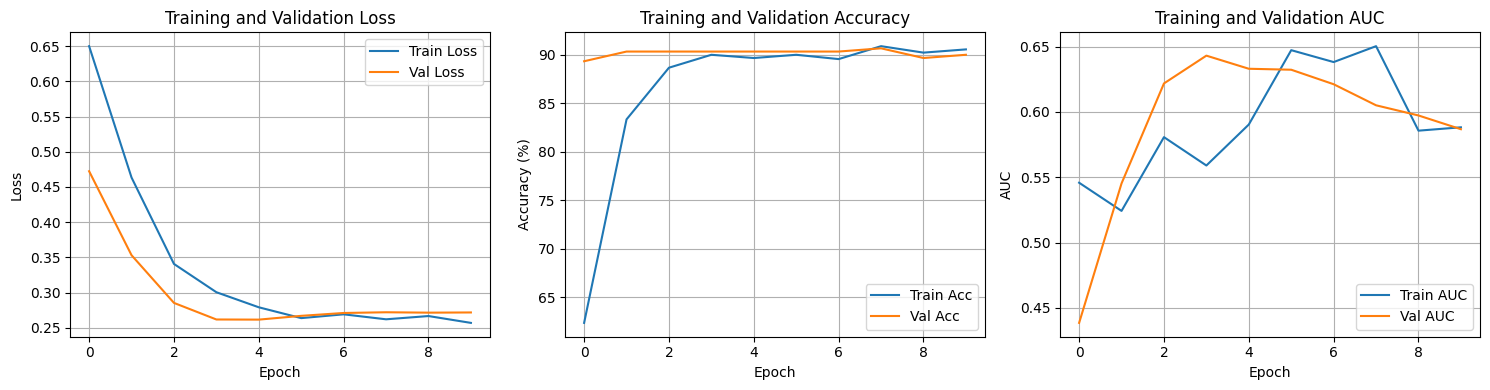

In [29]:
# Plot the training history
plot_training_history(history)

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]


Test Results:
  Loss: 0.2534
  Accuracy: 91.33%
  AUC: 0.5854


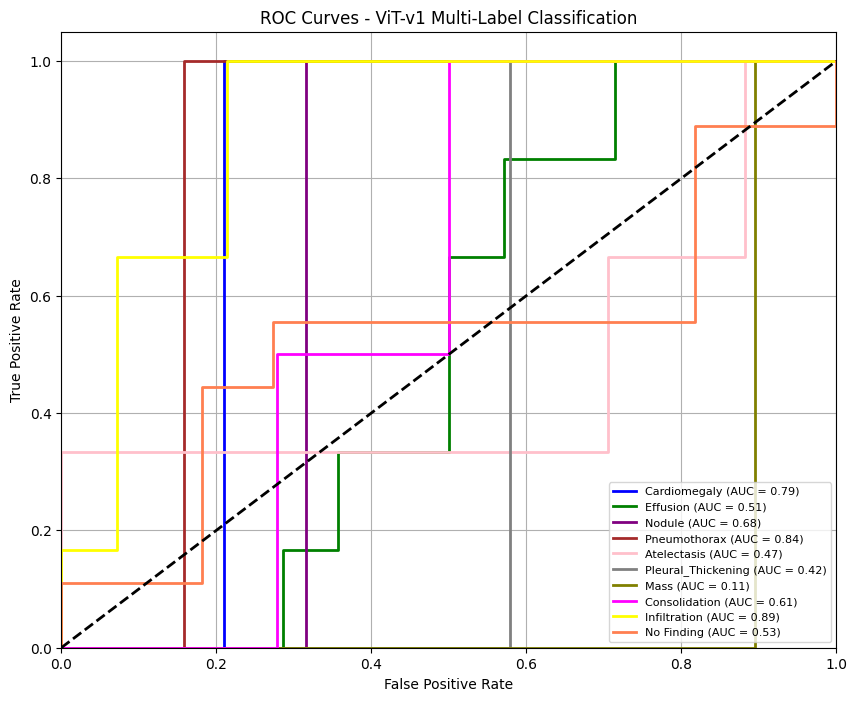

In [30]:
# Evaluate on test set and plot ROC curves
def evaluate_and_plot_roc(model, test_loader, num_classes, class_labels):
    """Evaluate model on test set and plot ROC curves"""
    model.eval()
    all_targets = []
    all_outputs = []
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    
    criterion = nn.BCEWithLogitsLoss()
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Evaluating'):
            images, labels = images.to(device), labels.to(device).float()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item() * images.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            test_correct += (preds == labels).sum().item()
            test_total += labels.numel()
            
            all_targets.append(labels.cpu().numpy())
            all_outputs.append(torch.sigmoid(outputs).cpu().numpy())
    
    # Calculate metrics
    test_loss = test_loss / len(test_loader.dataset)
    test_acc = test_correct / test_total * 100
    
    all_targets = np.vstack(all_targets)
    all_outputs = np.vstack(all_outputs)
    
    # Calculate AUC
    try:
        valid_classes = [i for i in range(all_targets.shape[1]) 
                       if len(np.unique(all_targets[:, i])) > 1]
        if len(valid_classes) > 0:
            test_auc = roc_auc_score(
                all_targets[:, valid_classes],
                all_outputs[:, valid_classes],
                average='macro'
            )
        else:
            test_auc = 0.0
    except ValueError:
        test_auc = 0.0
    
    print(f"\nTest Results:")
    print(f"  Loss: {test_loss:.4f}")
    print(f"  Accuracy: {test_acc:.2f}%")
    print(f"  AUC: {test_auc:.4f}")
    
    # Plot ROC curves
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(num_classes):
        if len(np.unique(all_targets[:, i])) > 1:
            fpr[i], tpr[i], _ = roc_curve(all_targets[:, i], all_outputs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure(figsize=(10, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 
                    'gray', 'olive', 'cyan', 'magenta', 'yellow', 'lime', 'navy', 'coral'])
    
    for i, color in zip(range(num_classes), colors):
        if i in roc_auc:
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                    label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - ViT-v1 Multi-Label Classification')
    plt.legend(loc='lower right', fontsize=8)
    plt.grid(True)
    plt.savefig('files/vit_v1_roc_curves.png', dpi=150)
    plt.show()
    
    return test_loss, test_acc, test_auc

# Evaluate
test_loss, test_acc, test_auc = evaluate_and_plot_roc(
    vit_model, test_loader, num_classes, parser.labels
)